# Image Captioning using LSTM on Flickr8K dataset

## Downloading Data and Dependencies

In [ ]:
#downloading the data
# !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
# !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

In [ ]:
#unzipping
!unzip Flickr8k_Dataset.zip -d all_images
!unzip Flickr8k_text.zip -d all_captions

In [ ]:
#importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tqdm import tqdm
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from numpy import array
import pickle
import numpy as np
import os
import cv2

## Data Visualization and Preprocessing

In [ ]:
#converting the text files to pandas dataframe
image_tokens=pd.read_csv("all_captions/Flickr8k.lemma.token.txt",sep='\t',names=["img_id","img_caption"])
train_image_names=pd.read_csv("all_captions/Flickr_8k.trainImages.txt",names=["img_id"])
test_image_names=pd.read_csv("all_captions/Flickr_8k.testImages.txt",names=["img_id"])
val_image_names=pd.read_csv("all_captions/Flickr_8k.devImages.txt",names=["img_id"])

In [ ]:
#just checking the number of images in the dataset
l=os.listdir("all_images/Flicker8k_Dataset")
print(len(l))

8091


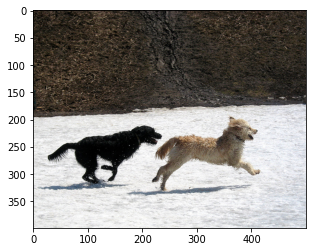

In [ ]:
#visualising one of the train images
img=cv2.imread("all_images/Flicker8k_Dataset"+ "/" +train_image_names.img_id[0])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [ ]:
#removing the #0,#1,#2,#3,#5 from the image ids
image_tokens["img_id"]=image_tokens["img_id"].map(lambda x: x[:len(x)-2])

In [ ]:
image_tokens["img_caption"]=image_tokens["img_caption"].map(lambda x: "<start> " + x.strip() + " <end>")

In [ ]:
#head of the image_tokens dataframe
image_tokens.head()

,img_id,img_caption
0,1305564994_00513f9a5b.jpg,<start> A man in street racer armor be examine...
1,1305564994_00513f9a5b.jpg,<start> Two racer drive a white bike down a ro...
2,1305564994_00513f9a5b.jpg,<start> Two motorist be ride along on their ve...
3,1305564994_00513f9a5b.jpg,<start> Two person be in a small race car driv...
4,1305564994_00513f9a5b.jpg,<start> Two person in race uniform in a street...


In [ ]:
#head of the train_image_names dataframe
train_image_names.head()

,img_id
0,2513260012_03d33305cf.jpg
1,2903617548_d3e38d7f88.jpg
2,3338291921_fe7ae0c8f8.jpg
3,488416045_1c6d903fe0.jpg
4,2644326817_8f45080b87.jpg


### Creating dictionaries to map image_id and their corresponding captions

In [ ]:
#creating train dictionary having key as the image id and value as a list of its captions
train_captions={}
for i in tqdm(range(len(train_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==train_image_names["img_id"].iloc[i]].img_caption)]
  train_captions[train_image_names["img_id"].iloc[i]]=l

100%|██████████| 6000/6000 [00:16<00:00, 366.95it/s]


In [ ]:
#creating test dictionary having key as the image id and value as a list of its captions
test_captions={}
for i in tqdm(range(len(test_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==test_image_names["img_id"].iloc[i]].img_caption)]
  test_captions[test_image_names["img_id"].iloc[i]]=l

100%|██████████| 1000/1000 [00:02<00:00, 362.24it/s]


In [ ]:
#creating validation dictionary having key as the image id and value as a list of its captions
validation_captions={}
for i in tqdm(range(len(val_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==val_image_names["img_id"].iloc[i]].img_caption)]
  validation_captions[val_image_names["img_id"].iloc[i]]=l

100%|██████████| 1000/1000 [00:02<00:00, 365.02it/s]


### ResNet50 model for encoding images

In [ ]:
model=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))
model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

### Encoding images and forming dictionaries containing mapping of image_id to image encodings

In [ ]:
#extracting image encodings(features) from resnet50 and forming dict train_features
path="all_images/Flicker8k_Dataset/"
train_features={}
c=0
for image_name in tqdm(train_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  train_features[image_name]=features.squeeze()

100%|██████████| 6000/6000 [06:33<00:00, 15.24it/s]


In [ ]:
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_features, pickle_f )

In [ ]:
#extracting image encodings(features) from resnet50 and forming dict test_features
path="all_images/Flicker8k_Dataset/"
test_features={}
c=0
for image_name in tqdm(test_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  test_features[image_name]=features.squeeze()

100%|██████████| 1000/1000 [01:05<00:00, 15.17it/s]


In [ ]:
with open( "test_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(test_features, pickle_f )

In [ ]:
#extracting image encodings(features) from resnet50 and forming dict validation_features
path="all_images/Flicker8k_Dataset/"
validation_features={}
c=0
for image_name in tqdm(validation_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  validation_features[image_name]=features.squeeze()

100%|██████████| 1000/1000 [01:05<00:00, 15.19it/s]


In [ ]:
with open( "validation_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(validation_features, pickle_f )

### Setting hyper parameters for vocabulary size and maximum length

In [ ]:
all_captions=[]
for img_id in tqdm(train_captions):
  for captions in train_captions[img_id]:
    all_captions.append(captions)

all_words=" ".join(all_captions)
print()
print(len(all_words))
unique_words=list(set(all_words.strip().split(" ")))
print(len(unique_words))

100%|██████████| 6000/6000 [00:00<00:00, 485836.10it/s]



1991192
6328


In [ ]:
#defining max_length and vocabulary size
vocab_size=len(unique_words)+1
max_length=40

### Creating dictionaries containg mapping of words to indices and indices to words

In [ ]:
#forming dictionaries containg mapping of words to indices and indices to words
words_to_indices={val:index+1 for index, val in enumerate(unique_words)}
indices_to_words = { index+1:val for index, val in enumerate(unique_words)}
words_to_indices["Unk"]=0
indices_to_words[0]="Unk"

### Transforming data into dictonary mapping of image_id to encoded captions

In [ ]:
#forming dictionary having encoded captions
train_encoded_captions={}
for img_id in tqdm(train_captions):
  train_encoded_captions[img_id]=[]
  for i in range(5):
    train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])

100%|██████████| 6000/6000 [00:00<00:00, 48349.23it/s]


In [ ]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

  0%|          | 0/6000 [00:00<?, ?it/s]

[[466, 2258, 5635, 5465, 686, 39, 4860, 3331, 1448, 5465, 3444, 2101, 4362, 442, 902], [466, 2574, 5465, 153, 823, 5465, 3420, 4362, 902], [466, 5739, 5465, 153, 4718, 5206, 4775, 2101, 2596, 5471, 442, 902], [466, 5739, 5465, 5586, 5811, 3444, 2101, 4362, 442, 902], [466, 5739, 5465, 39, 3420, 3331, 6165, 5482, 3623, 5276, 1046, 442, 902]]


In [ ]:
for img_id in tqdm(train_encoded_captions):
  train_encoded_captions[img_id]=pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')

100%|██████████| 6000/6000 [00:00<00:00, 24903.02it/s]


In [ ]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

  0%|          | 0/6000 [00:00<?, ?it/s]

[[ 466 2258 5635 5465  686   39 4860 3331 1448 5465 3444 2101 4362  442
   902    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 466 2574 5465  153  823 5465 3420 4362  902    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 466 5739 5465  153 4718 5206 4775 2101 2596 5471  442  902    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 466 5739 5465 5586 5811 3444 2101 4362  442  902    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 466 5739 5465   39 3420 3331 6165 5482 3623 5276 1046  442  902    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [ ]:
for x in train_encoded_captions['2513260012_03d33305cf.jpg'][2]:
  print(indices_to_words[x])

<start>
Two
dog
chase
each
other
across
the
snowy
ground
.
<end>
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk


In [ ]:
train_encoded_captions["2513260012_03d33305cf.jpg"][0][0:1].tolist()

[466]

## Data Generator for Modelling

In [ ]:
def data_generator(train_encoded_captions,train_features,num_of_photos):
  X1, X2, Y = list(), list(), list()
  max_length=40
  n=0
  for img_id in tqdm(train_encoded_captions):
    n+=1
    for i in range(5):
      for j in range(1,40):
        curr_sequence=train_encoded_captions[img_id][i][0:j].tolist()
        next_word=train_encoded_captions[img_id][i][j]
        curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
        one_hot_next_word=to_categorical([next_word],vocab_size)[0]
        X1.append(train_features[img_id])
        X2.append(curr_sequence)
        Y.append(one_hot_next_word)
    if(n==num_of_photos):
      yield [[array(X1), array(X2)], array(Y)]
      X1, X2, Y = list(), list(), list()
      n=0

## Modelling

In [ ]:
#importing dependencies
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.recurrent import LSTM
from keras.layers.merge import add
from keras.layers.embeddings import Embedding

In [ ]:
for i in train_features:
  print(train_features[i].shape)
  break

(2048,)


## Model

In [ ]:
#model
input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=LSTM(256)(dropout_2)

add_1=add([dense_1,lstm_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 256)      1620224     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                              

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


In [ ]:
len(train_encoded_captions)

6000

## Training

In [ ]:
epochs=1
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

In [ ]:
epochs=5
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

In [ ]:
test_features

## Greedy Search function

In [ ]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  #final = " ".join(final)
  return final

## Predicting Captions on Test Set using Greedy Search

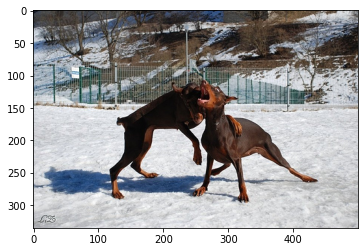

Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
A doberman be run through the grass .
bleu score:  0.7825422900366437


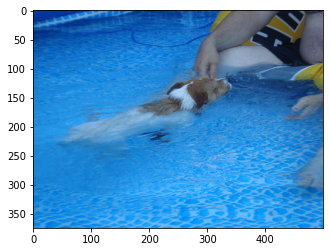

Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A boy be jump into a pool .
bleu score:  0.32347562464306545


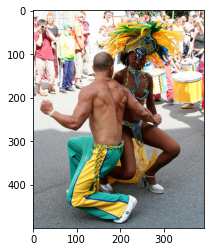

Referance Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .
Predicted Caption: 
A man in a red shirt be sit on a street .
bleu score:  0.6076795808137692


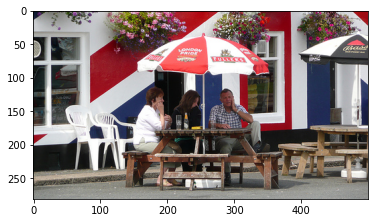

Referance Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption: 
A man in a white shirt be jump in a park .
bleu score:  0.7736620501360001


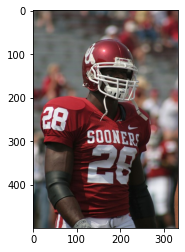

Referance Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .
Predicted Caption: 
A football player in a red helmet .
bleu score:  0.8091067115702212


In [ ]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("all_images/Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==5):
    break

## Calculating Average Bleu Score on Test Set using Greedy Search

In [ ]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Greedy search")
print("Score: ",avg_score)

100%|██████████| 1000/1000 [13:34<00:00,  1.23it/s]


Bleu score on Greedy search
Score:  0.4776410409015063


## Beam Search Function

In [48]:
def beam_search(photo,k):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
  sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
  y_pred = model.predict([photo,sequence],verbose=0)
  predicted=[]
  y_pred=y_pred.reshape(-1)
  for i in range(y_pred.shape[0]):
    predicted.append((i,y_pred[i]))
  predicted=sorted(predicted,key=lambda x:x[1])[::-1]
  b_search=[]
  for i in range(k):
    word = indices_to_words[predicted[i][0]]
    b_search.append((in_text +' ' + word,predicted[i][1]))
    
  for idx in range(max_length):
    b_search_square=[]
    for text in b_search:
      if text[0].split(" ")[-1]=="<end>":
        break
      sequence = [words_to_indices[s] for s in text[0].split(" ") if s in words_to_indices]
      sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
      y_pred = model.predict([photo,sequence],verbose=0)
      predicted=[]
      y_pred=y_pred.reshape(-1)
      for i in range(y_pred.shape[0]):
        predicted.append((i,y_pred[i]))
      predicted=sorted(predicted,key=lambda x:x[1])[::-1]
      for i in range(k):
        word = indices_to_words[predicted[i][0]]
        b_search_square.append((text[0] +' ' + word,predicted[i][1]*text[1]))
    if(len(b_search_square)>0):
      b_search=(sorted(b_search_square,key=lambda x:x[1])[::-1])[:5]
  final=b_search[0][0].split()
  final = final[1:-1]
  #final=" ".join(final)
  return final

## Predicting Captions on Test Set using Beam Search with k=3

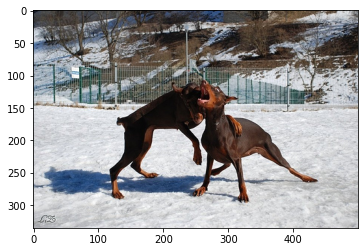

Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
A doberman jump in the snow .
bleu score:  0.41113361690051975


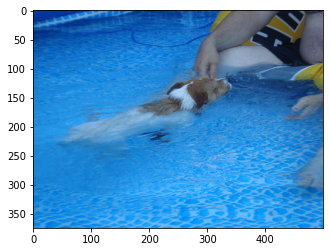

Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A little boy be jump into a pool .
bleu score:  0.33584386823726153


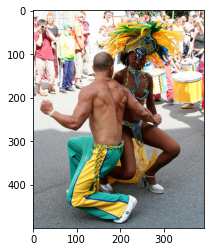

Referance Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .
Predicted Caption: 
A man in a red shirt be sit on a street .
bleu score:  0.6076795808137692


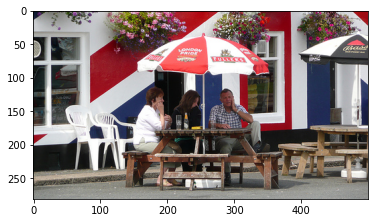

Referance Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption: 
A man in a pink shirt be jump in a park .
bleu score:  0.7736620501360001


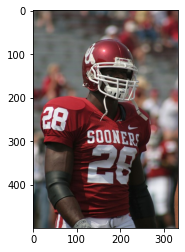

Referance Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .
Predicted Caption: 
A football player in a red helmet .
bleu score:  0.8091067115702212


In [49]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("all_images/Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==5):
    break

## Calculating Average Bleu Score on Test Set using Beam Search with k=3

In [ ]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Beam search with k=3")
print("Score: ",avg_score)

100%|██████████| 1000/1000 [53:42<00:00,  3.22s/it]


Bleu score on Beam search with k=3
Score:  0.4930332459159616
